In [97]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 1.3 MB/s eta 0:01:37
   ---------------------------------------- 0.8/124.9 MB 1.3 MB/s eta 0:01:37
   ---------------------------------------- 1.0/124.9 MB 1.3 MB/s eta 0:01:37
   ---------------------------------------- 1.3/124.9 MB 1.3 MB/s eta 0:01:36
    --------------------------------------- 1.6/124.9 MB 1.3 MB/s eta 0:01:36
    --------------------------------------- 1.8/124.9 MB 1.3 MB/s eta 0:01:36
    --------------------------------------- 2.1/124.9 MB 1.3 MB/s eta 0:01:36
    --------------------------------------- 2.4/124.9 MB 1.3 MB/s eta 0:01:35
    --------------------------------------- 2.6/124.9 MB 1.3 MB/s eta 0:01:35
    --------------------------------------- 2.9/124.9 MB 1.3 MB/s eta 0:01:35
   - -------------------------------------- 3.1/124.9 MB 1.3 MB/s eta 0:01:35


In [156]:
!pip install pystan==2.19.1.1
!pip install prophet


  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pystan
Failed to build pystan


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [4 lines of output]
  C:\Users\ravit\AppData\Local\Temp\pip-install-zd5mqjvn\pystan_bec6d40993954c4db9da0e8ba172487f\setup.py:61: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
    self.version = node.value.s
  Cython>=0.22 and NumPy are required.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


  Using cached holidays-0.66-py3-none-any.whl.metadata (26 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.3/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 1.2 MB/s eta 0:00:11
   -- ------------------------------------- 0.8/13.3 MB 1.0 MB/s eta 0:00:12
   --- ------------------------------------ 1.0/13.3 MB 1.1 MB/s eta 0:00:12
   --- ------------------------------------ 1.3/13.3 MB 1.1 MB/s eta 0:00:11
   ---- ----------------------------------- 1.6/13.3 MB 1.1 MB/s eta 0:00:11
   ---- ----------------------------------- 1.6/13.3 MB 1.1 MB/s eta 0:00:11
   ----- ---------------------------------- 1.8/13.3 MB 1.1 MB/s eta 0:00:11
   ------ --------------------------------- 2.1/13.3 MB 1.1 MB/s eta 0:00:11
   ------- -------------------------------- 2.4/13.3 MB 1.0 MB/s eta 0:00:11
   ------- -----------------------

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.cluster import DBSCAN
from prophet import Prophet


In [160]:
file_path= "OneHotEncoded_Global_EV_2023_Unit.csv"
df=pd.read_csv(file_path)


In [162]:
# charging point rati: it is the number of electric vehicles per charging station 
df['EV_per_ChargingPoint'] = df['value'] / (df['unit_charging points'] + 1e-6) 
df = df[df['year'] <= 2025] 
# a plot of ev growth and the current charging infrastructure 
ev_trend = df.groupby('year').agg({'unit_Vehicles': 'sum', 'unit_charging points': 'sum'}).reset_index()


In [164]:
features = ['unit_Vehicles', 'unit_charging points', 'EV_per_ChargingPoint', 'value', 'year']
target= 'OBC_Demand'
df[target] = df['unit_Vehicles'] / (df['unit_charging points'] + 1e-6)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [166]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [168]:
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [170]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

RMSE: 0.21791455769988616
R² Score: 0.9999999999998099


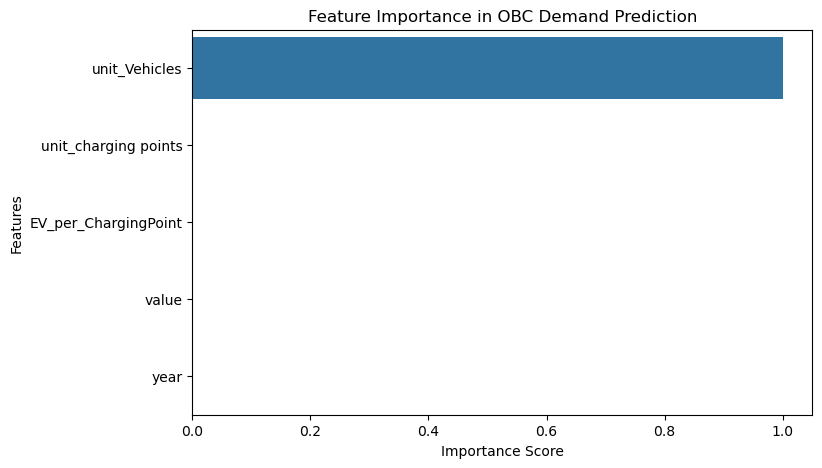

In [172]:
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in OBC Demand Prediction')
plt.show()


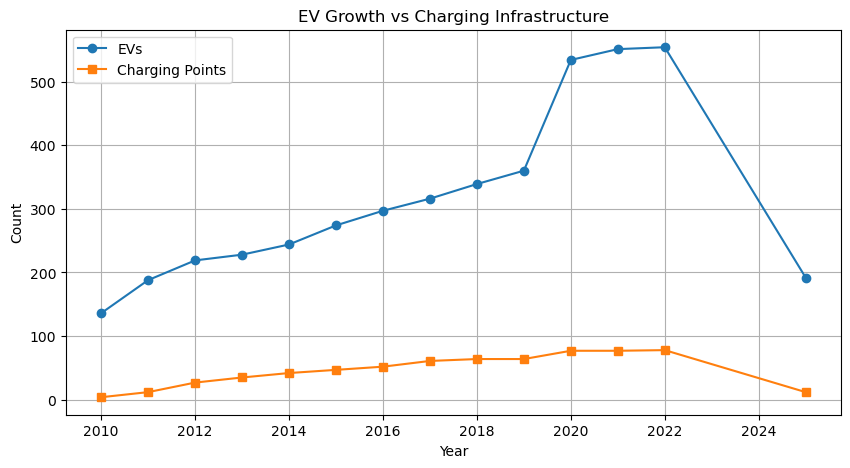

In [174]:
plt.figure(figsize=(10, 5))
plt.plot(ev_trend['year'], ev_trend['unit_Vehicles'], label='EVs', marker='o')
plt.plot(ev_trend['year'], ev_trend['unit_charging points'], label='Charging Points', marker='s')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('EV Growth vs Charging Infrastructure')
plt.legend()
plt.grid()
plt.show()


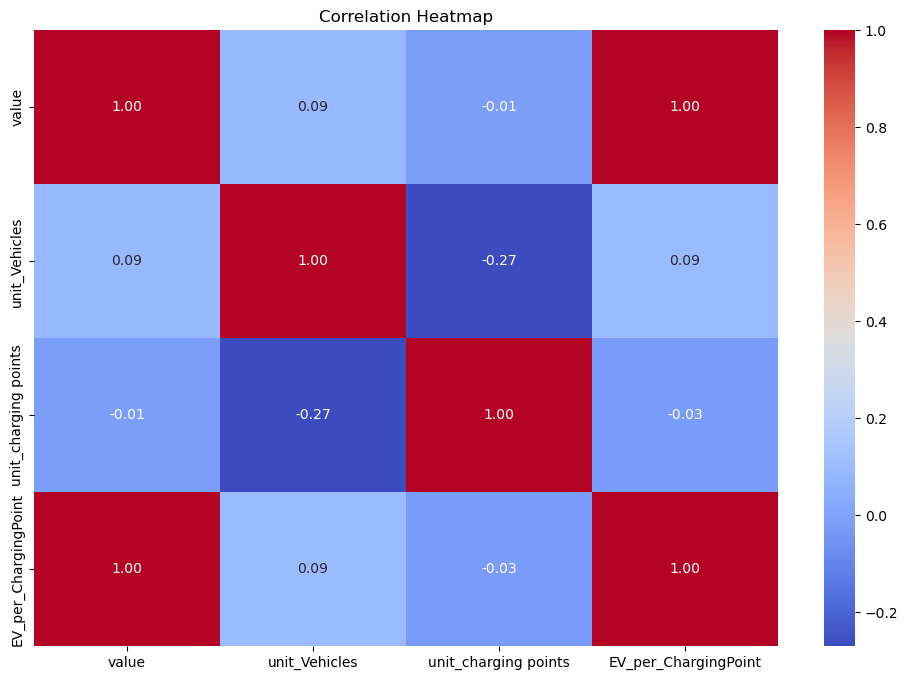

In [176]:
# we build a correlation matrix to find out the relation between the parameters 'value', 'unit_vehicles', 'unit_charging_points', EV_per_ChargingPoint'
# correlation matrix helps us visualize how one parameter influences the other
correlation_matrix=df[['value', 'unit_Vehicles', 'unit_charging points', 'EV_per_ChargingPoint']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot= True, cmap= 'coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [178]:
# now we cluster our data to identify high OBC demand region all over the world based on the provided dataset
features = df[['unit_Vehicles', 'unit_charging points', 'EV_per_ChargingPoint', 'value']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
#kmeans=KMeans(n_clusters=3, random_state=42, n_init=10)
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(features_scaled) 
print("Unique Clusters Identified:", df['Cluster'].unique())
#df['Cluster']=kmeans.fit_predict(features_scaled)

Unique Clusters Identified: [ 0 -1  1  2  3  4  5]


In [179]:
print(df['Cluster'].value_counts())
cluster_summary = df.groupby('Cluster').agg({
    'unit_Vehicles': 'mean',
    'unit_charging points': 'mean',
    'EV_per_ChargingPoint': 'mean'
}).reset_index()

print(cluster_summary)


Cluster
 1    4378
 4    4014
 0     651
-1      23
 2      15
 3      11
 5       6
Name: count, dtype: int64
   Cluster  unit_Vehicles  unit_charging points  EV_per_ChargingPoint
0       -1       0.956522              0.043478          1.686522e+13
1        0       0.000000              1.000000          4.423871e+04
2        1       1.000000              0.000000          8.883879e+10
3        2       1.000000              0.000000          4.653333e+12
4        3       1.000000              0.000000          8.163636e+12
5        4       0.000000              0.000000          1.049814e+09
6        5       1.000000              0.000000          1.100000e+13


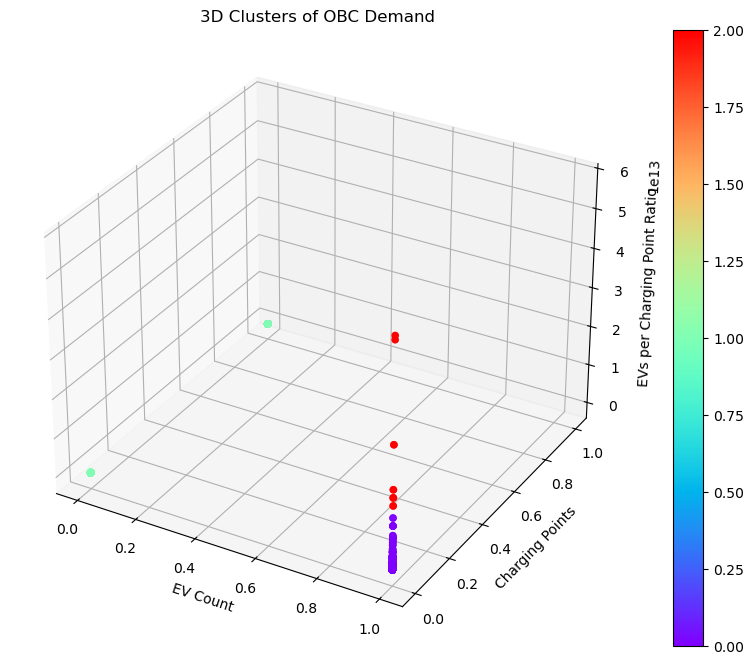

In [63]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=df['unit_Vehicles'], y=df['EV_per_ChargingPoint'], hue=df['Cluster'], palette='bright')
plt.xlabel('EV count')
plt.ylabel('EVs per Charging Point Ratio')
plt.title('Clusters of OBC demand')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#from the above plot it is visualized that cluster 1 is high implying that there are region with high EV adoption but fewer charging stations, suggesting a high demand for On-board chargers due to charging constraints

14:19:34 - cmdstanpy - INFO - Chain [1] start processing
14:19:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\ravit\AppData\Local\Temp\ipykernel_43300\1268733783.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(start="2024-01-01", end="2034-12-31", freq="Y")


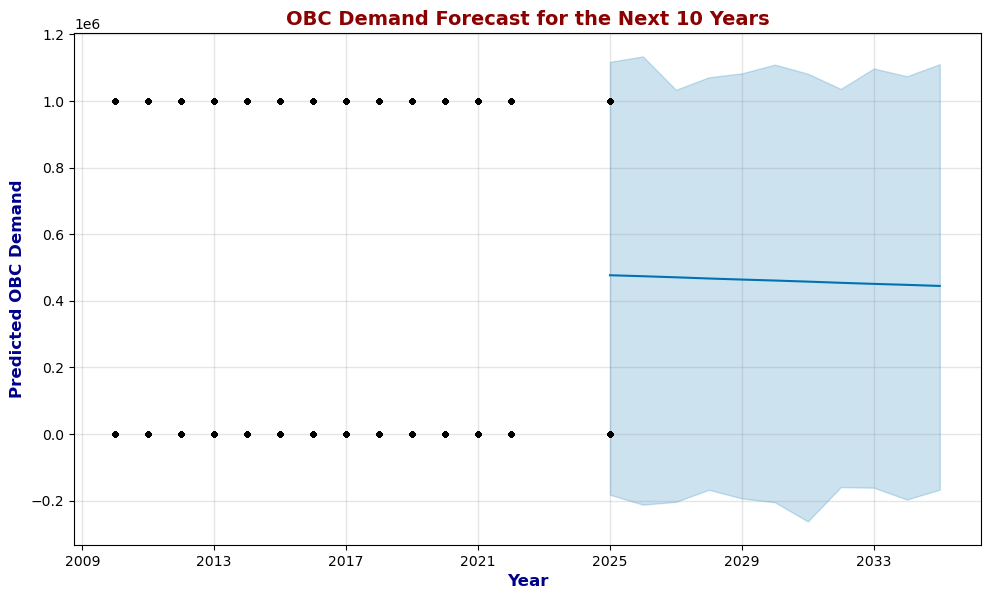

In [198]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')
model = Prophet()
model.fit(df_prophet)
future_dates = pd.date_range(start="2024-01-01", end="2034-12-31", freq="Y")
future = pd.DataFrame({'ds': future_dates})

forecast = model.predict(future)
fig = model.plot(forecast)
plt.xlabel('Year', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted OBC Demand', fontsize=12, fontweight='bold', color='darkblue')
plt.title('OBC Demand Forecast for the Next 10 Years', fontsize=14, fontweight='bold', color='darkred')
plt.show()
